In [1]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)

In [2]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);

In [3]:
import numpy
import pandas as pd

In [112]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt

def plot_blood_glucose(y_train, y_test=None):
    plt.figure(figsize=(12, 6))
    
    # Plot y_train
    plt.plot(y_train, label='Train', color='blue', marker='o')
    
    # Plot y_test if provided, without shifting
    if y_test is not None:
        plt.plot(y_test, label='Test', color='orange', marker='x')

    # Add labels, title, and legend
    plt.title('Blood Glucose Levels (Train and Test)')
    plt.xlabel('Time')
    plt.ylabel('Blood Glucose Level')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def split_and_plot_blood_glucose(split, time_series_data, forecast_horizon=5, train_size=0.75):
    """
    Function to split the time series into train and test using TimeSeriesSplit and plot them.
    
    Parameters:
    - time_series_data: The time series data to split
    - n_splits: Number of splits for TimeSeriesSplit
    - forecast_horizon: Size of the test set (forecast horizon)
    - train_size: Proportion of data used for training
    """
    
    # Ensure the index is a DatetimeIndex
    if not isinstance(time_series_data.index, pd.DatetimeIndex):
        raise ValueError("The index of the time series must be a DatetimeIndex.")
    
    # Calculate train size in terms of number of observations
    total_size = len(time_series_data)
    train_size_obs = int(total_size * train_size)

    # Split the time series using TimeSeriesSplit
    tscv = split

    for train_index, test_index in tscv.split(time_series_data):
        # Apply forecast horizon to the test split
        y_train, y_test = time_series_data.iloc[train_index], time_series_data.iloc[test_index][:forecast_horizon]
        plot_blood_glucose(y_train, y_test)

    return tscv

# Example usage:
# plot_blood_glucose(y_train, y_test=None)  # In case y_test is None


# Example usage:
# plot_blood_glucose(y_train, y_test=None)  # In case y_test is None


# Example usage:
# plot_blood_glucose(time_series_data, start=0, end=30)


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


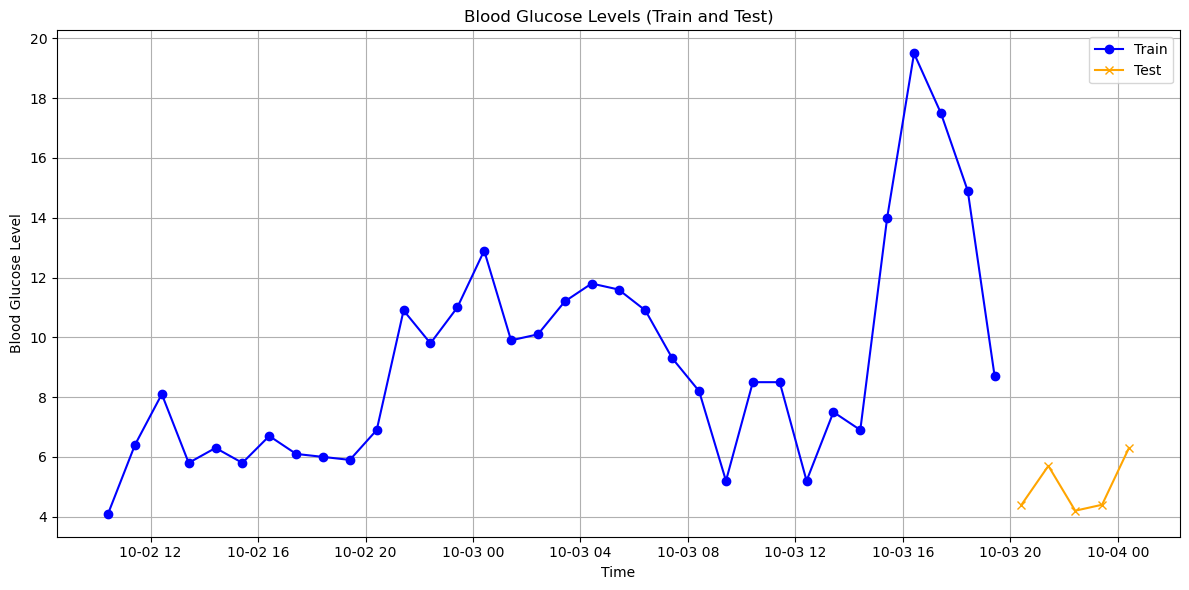

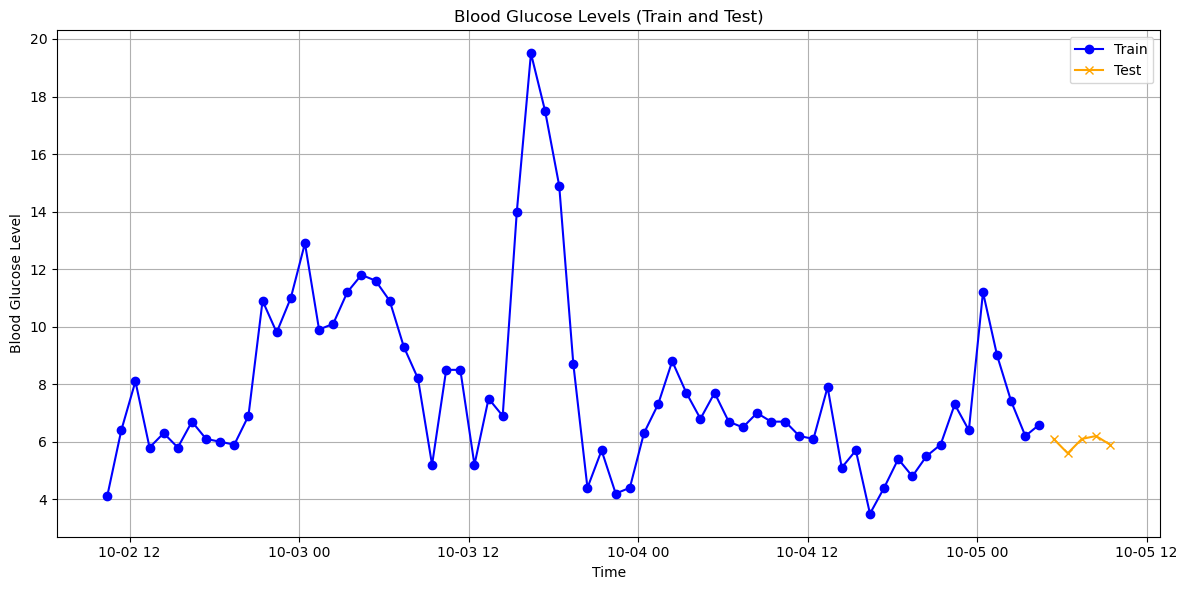

In [113]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Read and process the data
time_series_data = pd.read_csv(r"..\data/processed/cleaned_up_patients/p12.csv")

# Ensure that 'time' is a DatetimeIndex
time_series_data['time'] = pd.to_datetime(time_series_data['time'])
time_series_data.set_index('time', inplace=True)

# Extract the 'bg' column as a Series for the first 30 rows
test = time_series_data['bg'].iloc[:100]

# Ensure the index is a DatetimeIndex
print(type(test.index))  # Should be <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

# Use TimeSeriesSplit to split the data into train and test
tscv = TimeSeriesSplit(n_splits=2)  # n_splits = 2 will give you a simple train-test split

splitter = split_and_plot_blood_glucose(tscv, test, forecast_horizon=5, train_size=0.75)


In [115]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

def cross_validate_exponential_smoothing(time_series_data, n_splits=5, forecast_horizon=5, train_size=0.75):
    """
    Perform cross-validation using Exponential Smoothing, train on the train set, 
    forecast on the test set, and calculate the loss for each fold.
    
    Parameters:
    - time_series_data: pandas Series with a DatetimeIndex
    - n_splits: Number of splits for TimeSeriesSplit
    - forecast_horizon: Number of steps to forecast (size of test set)
    - train_size: Proportion of the dataset used for training in each fold (0 < train_size < 1)
    
    Returns:
    - losses: A list of Mean Squared Error (MSE) losses for each fold
    """

    # Ensure the index is a DatetimeIndex
    if not isinstance(time_series_data.index, pd.DatetimeIndex):
        raise ValueError("The index of the time series must be a DatetimeIndex.")
    
    # Calculate number of train samples based on train_size
    total_size = len(time_series_data)
    train_size_obs = int(total_size * train_size)
    
    # Initialize TimeSeriesSplit with the desired number of splits
    tscv = TimeSeriesSplit(n_splits=n_splits)
    losses = []

    # Loop through each fold of the TimeSeriesSplit
    for fold, (train_index, test_index) in enumerate(tscv.split(time_series_data)):
        # Ensure that we only use train_size proportion of the training data
        train_index = train_index[-train_size_obs:]  # Use only the last train_size_obs data points
        
        # Train and test data for the current fold
        y_train = time_series_data.iloc[train_index]
        y_test = time_series_data.iloc[test_index][:forecast_horizon]

        print(f"Fold {fold + 1} Training set size: {len(y_train)}, Test set size: {len(y_test)}")
        
        # Train Exponential Smoothing on y_train
        model = ExponentialSmoothing(y_train, trend=None, seasonal='add', seasonal_periods=12)
        model_fit = model.fit()

        # Forecast on the test set
        y_pred = model_fit.forecast(steps=forecast_horizon)

        # Calculate the loss (MSE)
        loss = mean_squared_error(y_test, y_pred)
        losses.append(loss)
        print(f'Fold {fold + 1} Loss (MSE): {loss}')

        # Plot the results for the current fold
        plot_forecast_results(y_train, y_test, y_pred, fold + 1)

    return losses

def plot_forecast_results(y_train, y_test, y_pred, fold):
    """
    Helper function to plot the results of the train, test, and forecasted values.
    
    Parameters:
    - y_train: The training data
    - y_test: The test data (actual values)
    - y_pred: The predicted values (forecasted)
    - fold: Current fold number for display
    """
    plt.figure(figsize=(12, 6))

    # Plot the train data
    plt.plot(y_train.index, y_train.values, label='Train', color='blue', marker='o')

    # Plot the test data
    plt.plot(y_test.index, y_test.values, label='Test (Actual)', color='orange', marker='x')

    # Plot the forecasted data
    plt.plot(y_pred.index, y_pred.values, label='Forecast (Predicted)', color='green', linestyle='--')

    # Add title, labels, and legend
    plt.title(f'Fold {fold} - Train, Test, and Forecast')
    plt.xlabel('Time')
    plt.ylabel('Blood Glucose Level')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming `time_series_data` is your data with a DatetimeIndex
# time_series_data = pd.read_csv('your_data.csv', index_col='time', parse_dates=True)
# losses = cross_validate_exponential_smoothing(time_series_data, n_splits=5, forecast_horizon=5, train_size=0.75)


Fold 1 Training set size: 25, Test set size: 5
Fold 1 Loss (MSE): 13.907966058161318


C:\Users\rapha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


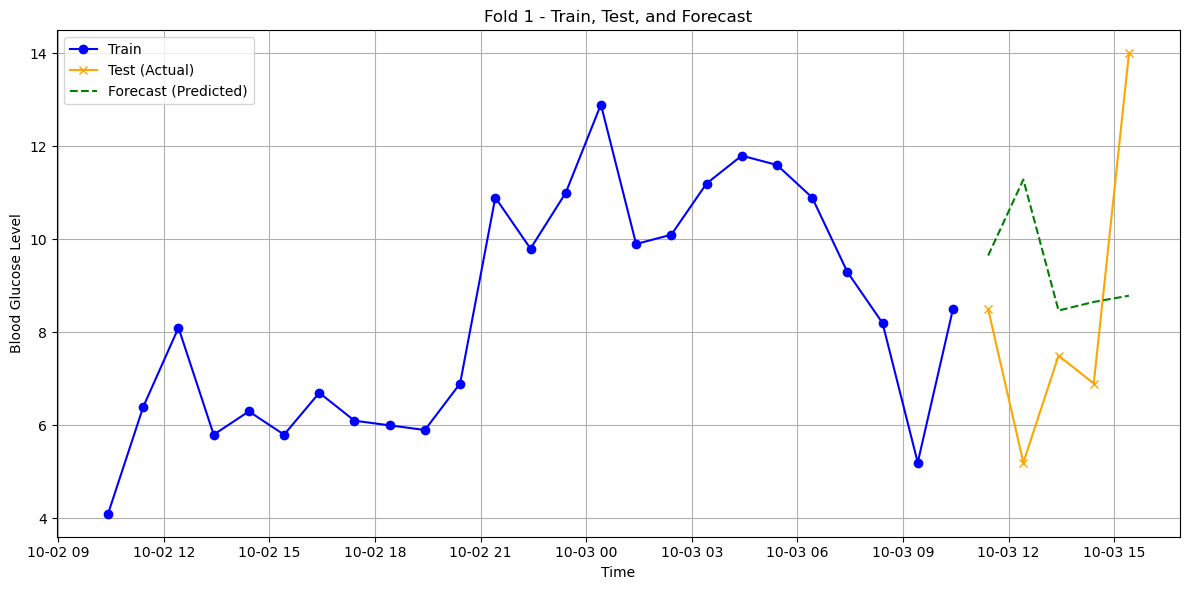

Fold 2 Training set size: 50, Test set size: 5
Fold 2 Loss (MSE): 9.928368660350289


C:\Users\rapha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


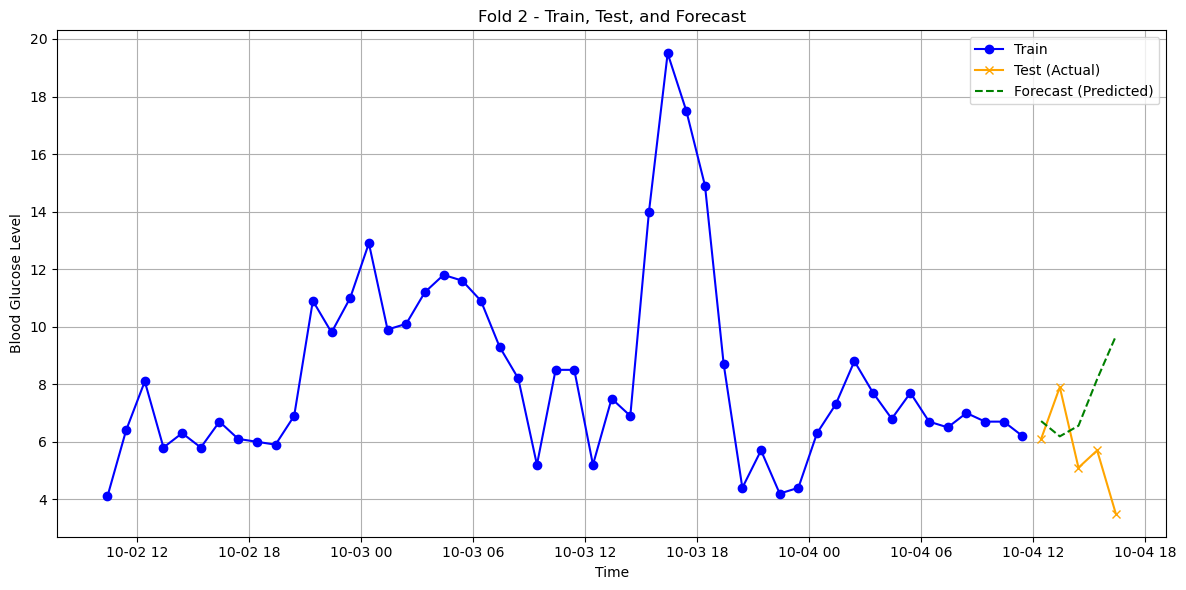

Fold 3 Training set size: 75, Test set size: 5
Fold 3 Loss (MSE): 7.59544393584927


C:\Users\rapha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [ ]:
time_series_data = test
#print(time_series_data)
losses = cross_validate_exponential_smoothing(test, n_splits=3, forecast_horizon=5)
